# Single ViT hyperparam  tuning


In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import tensorflow as tf
import librosa, librosa.display


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Reshape, MaxPooling2D, Softmax
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import SGD

from IPython import display
import random
from google.colab import drive


drive.mount('/content/drive/')
%cd 'drive/MyDrive/Colab Notebooks/DLOI/Project'

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/DLOI/Project


## Keras tuner 


In [2]:
!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

# random search: randomly samples hyperplane 
# BayesianOptimization : less comp. expensive than random search and better 

     |████████████████████████████████| 133 kB 30.9 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


Fixed hyperparameters 

In [3]:
# DATA
BATCH_SIZE = 16                                                                      

# AUGMENTATION
IMAGE_SIZE = 72                                                                 
                             
# OPTIMIZER
LEARNING_RATE = 0.001                                                                
WEIGHT_DECAY = 0.0001                                                                 

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6                                                                 

## Dataset

In [ ]:
# Download dataset
# !gdown 1-2_584NonvhhTgTEO0VBZrfooKxQujnT

In [4]:
# from scipy.sparse import load_npz
# data = load_npz('/content/drive/MyDrive/DLOI_Project/audVisIdn.npz')

path_person_test='dataset/person_test.npy'
path_person_train='dataset/person_train.npy'
path_person_val='dataset/person_val.npy'

path_imgFrames_test='dataset/imgFrames_test.npy'
path_imgFrames_train='dataset/imgFrames_train.npy'
path_imgFrames_val='dataset/imgFrames_val.npy'

person_test = np.load(path_person_test, mmap_mode='r')
person_train = np.load(path_person_train, mmap_mode='r')
person_val = np.load(path_person_val, mmap_mode='r')

imgFrames_test = np.load(path_imgFrames_test, mmap_mode='r')
imgFrames_train = np.load(path_imgFrames_train, mmap_mode='r')
imgFrames_val = np.load(path_imgFrames_val, mmap_mode='r')

print('Labels:')
print(np.shape(person_test)) 
print(np.shape(person_train)) 
print(np.shape(person_val)) 

print('Faces images :')
print(np.shape(imgFrames_test)) 
print(np.shape(imgFrames_train)) 
print(np.shape(imgFrames_val)) 

nb_img_train, input_size, input_size, nb_channel = np.shape(imgFrames_train)

download_audio_images = True # Set to false to do the Mel spectogram again

if download_audio_images: # Load Mel spectogram directly
  S_DB_val_path='audio/AudioImages_Val.npy'
  S_DB_path='audio/AudioImages_Train.npy'
  S_DB_test_path='audio/AudioImages_Test.npy'

  S_DB_val = abs(np.load(S_DB_val_path, mmap_mode='r'))
  S_DB_test = abs(np.load(S_DB_test_path, mmap_mode='r'))
  S_DB = abs(np.load(S_DB_path, mmap_mode='r'))

  print('Audio images')
  print(np.shape(S_DB_val)) 
  print(np.shape(S_DB_test)) 
  print(np.shape(S_DB)) 

else: # Load Raw speeches

  path_audioTrs_test='dataset/audioTrs_test.npy'
  path_audioTrs_train='dataset/audioTrs_train.npy'
  path_audioTrs_val='dataset/audioTrs_val.npy'

  audioTrs_test = np.load(path_audioTrs_test, mmap_mode='r')
  audioTrs_train = np.load(path_audioTrs_train, mmap_mode='r')
  audioTrs_val = np.load(path_audioTrs_val, mmap_mode='r')  

  print('Audio speech')
  print(np.shape(audioTrs_test)) 
  print(np.shape(audioTrs_train)) 
  print(np.shape(audioTrs_val)) 


Labels:
(950,)
(2850,)
(950,)
Faces images :
(950, 224, 224, 3)
(2850, 224, 224, 3)
(950, 224, 224, 3)
Audio images
(950, 128, 110, 3)
(950, 128, 110, 3)
(8550, 128, 110, 3)


Rescale the labels between 0 and 49

In [5]:
GT = list(np.unique(person_train))
new_id = [i for i in range(49)]
id_dict = {}
for k in range(len(GT)):
  id_dict[GT[k]] = new_id[k]

nb_class=49

person_train_GT = []
for i in range(person_train.shape[0]):
  person_train_GT.append(id_dict[person_train[i]]) 
person_train_GT = np.stack(person_train_GT)
output_train_class_onehot = tf.keras.utils.to_categorical(person_train_GT, nb_class)  # create one-hot encoded class

person_val_GT = []
for i in range(person_val.shape[0]):
  person_val_GT.append(id_dict[person_val[i]]) 
person_val_GT = np.stack(person_val_GT)
output_val_class_onehot = tf.keras.utils.to_categorical(person_val_GT, nb_class)  # create one-hot encoded class

person_test_GT = []
for i in range(person_test.shape[0]):
  person_test_GT.append(id_dict[person_test[i]]) 
person_test_GT = np.stack(person_test_GT)
output_test_class_onehot = tf.keras.utils.to_categorical(person_test_GT, nb_class)  # create one-hot encoded class
   
print('Labels GT:')
print(np.shape(person_test_GT)) 
print(np.shape(person_train_GT)) 
print(np.shape(person_val_GT)) 

Labels GT:
(950,)
(2850,)
(950,)


In [6]:
# Scale audio mel spectrogram values to match cv image range (0 - 255)
max_val = np.max([np.max(S_DB), np.max(S_DB_val), np.max(S_DB_test)])

S_DB = 255/max_val*S_DB # range 0 to 255
S_DB_val = 255/max_val*S_DB_val
S_DB_test = 255/max_val*S_DB_test

Data adaptation for transformers

In [7]:
# Downsampling
import cv2
def downsample_image(dataset, chosen_input_size):
  # INTER_LINEAR or INTER_AREA
  return [cv2.resize(image, (chosen_input_size, chosen_input_size), interpolation=cv2.INTER_AREA) for image in dataset]

down_sample=True  # True to downsample dataset
down_sampled=False
fuse = True

if down_sample and not down_sampled:
  if not fuse:
    chosen_input_size=S_DB[0].shape[1]

    imgFrames_train=np.array(downsample_image(S_DB, chosen_input_size))
    imgFrames_val=np.array(downsample_image(S_DB_val, chosen_input_size))
    INPUT_SHAPE = (chosen_input_size, chosen_input_size, nb_channel)

  else:
    fuse_id = []
    for i in range(S_DB.shape[0]):
      fuse_id.append(i%3 == 0)
    S_DB_fuse = S_DB[fuse_id]

    chosen_input_size=32
    INPUT_SHAPE_IMG = (chosen_input_size, chosen_input_size, nb_channel)
    imgFrames_train_img=np.array(downsample_image(imgFrames_train, chosen_input_size))
    imgFrames_val_img=np.array(downsample_image(imgFrames_val, chosen_input_size))
    imgFrames_test_img=np.array(downsample_image(imgFrames_test, chosen_input_size))

    chosen_input_size=S_DB[0].shape[1]
    INPUT_SHAPE_AUDIO = (chosen_input_size, chosen_input_size, nb_channel)

    imgFrames_train_audio=np.array(downsample_image(S_DB_fuse, chosen_input_size))
    imgFrames_val_audio=np.array(downsample_image(S_DB_val, chosen_input_size))
    imgFrames_test_audio=np.array(downsample_image(S_DB_test, chosen_input_size))

  down_sampled=True

elif not down_sample and not down_sampled:
  if not fuse:
    INPUT_SHAPE = (input_size, input_size, nb_channel)
  else:
    chosen_input_size = S_DB[0].shape[1]
    INPUT_SHAPE_AUDIO = (chosen_input_size, chosen_input_size, nb_channel)
    chosen_input_size = 32
    INPUT_SHAPE_IMG = (chosen_input_size, chosen_input_size, nb_channel)
else :
  print("Already downsampled")

NUM_CLASSES = nb_class


# Normalization and shuffle
norm = 1 # already performed in data-augmentation

if fuse:
  x_train_img=imgFrames_train_img/norm
  r=random.sample(range(len(x_train_img)), len(x_train_img)) # shuffle data
  x_train_img=x_train_img[r]
  y_train_fuse=person_train_GT[r]

  x_train_audio=imgFrames_train_audio/norm
  x_train_audio=x_train_audio[r]
  #y_train_audio=train_aug_GT[r]

  x_test_audio = imgFrames_test_audio/norm
  x_test_img = imgFrames_test_img/norm
  r=random.sample(range(len(x_test_audio)), len(x_test_audio)) # shuffle data
  x_test_audio=x_test_audio[r]
  x_test_img=x_test_img[r]

  y_test_fuse=person_test_GT[r]


  x_val_img=imgFrames_val_img/norm
  r=random.sample(range(len(x_val_img)), len(x_val_img))
  x_val_img=x_val_img[r]
  y_val_fuse=person_val_GT[r]

  x_val_audio=imgFrames_val_audio/norm
  x_val_audio=x_val_audio[r]
  #y_val_audio=person_val_GT[r]


else:
  x_train=imgFrames_train/norm
  r=random.sample(range(len(x_train)), len(x_train)) # shuffle data
  x_train=x_train[r]
  y_train=train_aug_GT[r]

  x_val=imgFrames_val/norm
  r=random.sample(range(len(x_val)), len(x_val))
  x_val=x_val[r]
  y_val=person_val_GT[r]


print('Images')
print(np.shape(x_train_img)) 
print(np.shape(x_val_img)) 
print(np.shape(x_test_img)) 

print('Audios ')
print(np.shape(x_train_audio)) 
print(np.shape(x_val_audio)) 
print(np.shape(x_test_audio)) 

print('Labels')
print(np.shape(y_train_fuse)) 
print(np.shape(y_val_fuse)) 
print(np.shape(y_test_fuse)) 

Images
(2850, 32, 32, 3)
(950, 32, 32, 3)
(950, 32, 32, 3)
Audios 
(2850, 110, 110, 3)
(950, 110, 110, 3)
(950, 110, 110, 3)
Labels
(2850,)
(950,)
(950,)


## Visual transformer definition


In [8]:
# ViT
!pip install -qq -U tensorflow-addons

import tensorflow_addons as tfa
import math

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

     |████████████████████████████████| 1.1 MB 9.5 MB/s 


Image data augmentation

In [9]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
if fuse:
  data_augmentation.layers[0].adapt(x_train_img)
else:
  data_augmentation.layers[0].adapt(x_train)

**Shifted Patch Tokenization (SPT)**

- Effectively solve the lack of locality inductive bias in a datset and enables to learn from scratch even on small-size datasets. 
- Implement SPT as a layer

In [10]:
class ShiftedPatchTokenization(layers.Layer, kt.HyperModel):
    def __init__(
        self, hp,
        image_size=IMAGE_SIZE,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to switch to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = hp.Choice('patch_size',values=[4, 6, 12, 18, 24]) 
        self.half_patch = self.patch_size // 2
        self.flatten_patches = layers.Reshape(((self.image_size // hp.Choice('patch_size',values=[4, 6, 12, 18, 24])) ** 2 , -1))
        self.projection = layers.Dense(units=hp.Choice('projection_dim',values=[32, 64, 128]))
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

**Patch encoding layer**
- Linearly transforms a patch by projecting it into a vector of size PROJECTION_DIM
- Adds a learnable position embedding to the projected vector

In [11]:
class PatchEncoder(layers.Layer, kt.HyperModel):
    def __init__(
        self, hp,  images_size=IMAGE_SIZE, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = (images_size // hp.Choice('patch_size',values=[4, 6, 12, 18, 24])) ** 2
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=hp.Choice('projection_dim',values=[32, 64, 128]) 
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

**Locality Self-Attention (LSA)**
- Mitigates the smoothing phenomenon of attention score distribution by excluding self-tokens and by applying learnable temperature to the softmax function
- Primarily sharpens the distribution of attention scores by learning the temperature parameters of the softmax function. 
- Then, removes the self-token relation by forcibly suppressing the diagonal components of the similarity matrix computed by Query and Key. This masking relatively increases the attention scores between different tokens, making the distribution of attention scores sharper. 
- As a result, LSA increases the locality inductive bias by making ViT’s attention locally focused. 

In [12]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

**MLP head**


In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
class Single_ViT_HyperModel(kt.HyperModel):

  def __init__(self,input_shape = INPUT_SHAPE_IMG):
    self.input_shape = input_shape

  def build(self, hp, vanilla=False, image_size=IMAGE_SIZE):
      # Build the diagonal attention mask
      diag_attn_mask = 1 - tf.eye((image_size // hp.Choice('patch_size',values=[4, 6, 12, 18, 24])) ** 2)
      diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
      
      inputs_img = layers.Input(shape=self.input_shape)
      # Augment data.
      augmented_img = data_augmentation(inputs_img)
      # Create patches.
      (tokens_img, _) = ShiftedPatchTokenization(hp, vanilla=vanilla)(augmented_img)
      # Encode patches.
      encoded_img_patches = PatchEncoder(hp)(tokens_img)

      # Create multiple layers of the Transformer block.
      for _ in range(hp.Choice('transformer_layers',values=[2, 4, 6, 8])):
          # Layer normalization 1.
          x1_img = layers.LayerNormalization(epsilon=1e-6)(encoded_img_patches)
          # Create a multi-head attention layer.
          if not vanilla:
              attention_output_img = MultiHeadAttentionLSA(
                  num_heads=hp.Choice('num_heads',values=[2,3,4,5,6,7,8]), key_dim=hp.Choice('projection_dim',values=[32, 64, 128]), dropout=0.1
              )(x1_img, x1_img, attention_mask=diag_attn_mask)
          else:
              attention_output_img = layers.MultiHeadAttention(
                  num_heads=hp.Choice('num_heads',values=[2,3,4,5,6,7,8]), key_dim=hp.Choice('projection_dim',values=[32, 64, 128]), dropout=0.1
              )(x1_img, x1_img)
          # Skip connection 1.
          x2_img = layers.Add()([attention_output_img, encoded_img_patches])
          # Layer normalization 2.
          x3_img = layers.LayerNormalization(epsilon=1e-6)(x2_img)
          # MLP.
          x3_img = mlp(x3_img, hidden_units=[hp.Choice('projection_dim',values=[32, 64, 128]) * 2, hp.Choice('projection_dim',values=[32, 64, 128]),] , dropout_rate=0.1)
          # Skip connection 2.
          encoded_img_patches = layers.Add()([x3_img, x2_img])
          # Create a [batch_size, projection_dim] tensor.
      representation_img = layers.LayerNormalization(epsilon=1e-6)(encoded_img_patches)
      representation_img = layers.Flatten()(representation_img)
      representation_img = layers.Dropout(0.5)(representation_img)
      representation_img = mlp(representation_img, hidden_units=[2*hp.Choice('mlp_head_units',values=[512, 256, 128]), hp.Choice('mlp_head_units',values=[512, 256, 128])], dropout_rate=0.5)

      # Add MLP
      features = mlp(representation_img, hidden_units=[2*hp.Choice('mlp_head_units',values=[512, 256, 128]), hp.Choice('mlp_head_units',values=[512, 256, 128])], dropout_rate=0.5)
      # Classify outputs.
      logits = layers.Dense(NUM_CLASSES)(features)
      # Create the Keras model
    
      model = keras.Model(inputs=inputs_img, outputs=logits)
      optimizer = tfa.optimizers.AdamW(
          learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
      )

      model.compile(
          optimizer=optimizer,
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=[
              keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
              keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
          ],
      )

      return model
    
  #def fit(self, hp, model, batch_size=BATCH_SIZE, *args, **kwargs):

  #    return model.fit(batch_size=batch_size,*args,**kwargs,)

In [15]:
def plot_loss_and_accuracy(history_sl):
  # model loss
  loss='categorical_crossentropy'
  metrics=['accuracy']

  plt.plot(history_sl.history['loss'])
  plt.plot(history_sl.history['val_loss'])
  plt.title('Model loss : ' + loss)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='best')
  plt.show()
  plt.close()

  # model accuracy metric
  plt.plot(np.array(history_sl.history[metrics[0]]))
  plt.plot(np.array(history_sl.history['val_' + metrics[0]]))
  plt.title('Model accuracy metric : ' + metrics[0])
  plt.ylabel('Accuracy metric')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='best')
  plt.show()
  plt.close()

## Face Images ViT tuning

### 1. Random tuner: objective = validation accuracy 

- max_trials: Integer, the total number of trials (model configurations) to test at most. Note that the oracle may interrupt the search before max_trial models have been tested if the search space has been exhausted.

In [ ]:
tuner_random_img = RandomSearch(Single_ViT_HyperModel(input_shape = INPUT_SHAPE_IMG), objective='val_accuracy', max_trials=50, executions_per_trial=1, project_name='Hyperparameters_random', overwrite=True)

In [ ]:
tuner_random_img.search_space_summary()

Search space summary
Default search space size: 5
patch_size (Choice)
{'default': 4, 'conditions': [], 'values': [4, 6, 12, 18, 24], 'ordered': True}
projection_dim (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
transformer_layers (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4, 6, 8], 'ordered': True}
num_heads (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5, 6, 7, 8], 'ordered': True}
mlp_head_units (Choice)
{'default': 512, 'conditions': [], 'values': [512, 256, 128], 'ordered': True}


In [ ]:
tuner_random_img.search(x_train_img, y_train_fuse, epochs=30,  validation_data=(x_val_img, y_val_fuse))

Trial 50 Complete [00h 01m 03s]
val_accuracy: 0.6578947305679321

Best val_accuracy So Far: 0.7273684144020081
Total elapsed time: 02h 40m 49s
INFO:tensorflow:Oracle triggered exit


For the Face images ViT, the best validation accuracy is 0.73

In [ ]:
best_hps_hyper_img = tuner_random_img.get_best_hyperparameters()[0]
print('For the Face images ViT, the best parameters are: ')
print(' - Patch size:            {}'.format(best_hps_hyper_img.get('patch_size')))
print(' - Projection dimension:  {}'.format(best_hps_hyper_img.get('projection_dim')))
print(' - Transformer layers:    {}'.format(best_hps_hyper_img.get('transformer_layers')))
print(' - Number of heads:       {}'.format(best_hps_hyper_img.get('num_heads')))
print(' - MLP head units:        [{}, {}]'.format(2*best_hps_hyper_img.get('mlp_head_units'), best_hps_hyper_img.get('mlp_head_units')))

For the Face images ViT, the best parameters are: 
 - Patch size:            18
 - Projection dimension:  32
 - Transformer layers:    6
 - Number of heads:       6
 - MLP head units:        [1024, 512]


In [ ]:
model = tuner_random_img.hypermodel.build(best_hps_hyper_img)
model.save('model_save')

INFO:tensorflow:Assets written to: model_save/assets


INFO:tensorflow:Assets written to: model_save/assets


Best model further training 

In [16]:
best_model_img = keras.models.load_model('model_save')

In [ ]:
max_epochs = 150
history_img = best_model_img.fit(x_train_img, y_train_fuse, batch_size = BATCH_SIZE,
                    epochs = max_epochs,
                    validation_data=(x_val_img, y_val_fuse),
                    shuffle = True)

Epoch 1/150
179/179 [==============================] - 21s 46ms/step - loss: 3.8051 - accuracy: 0.0916 - top-5-accuracy: 0.2446 - val_loss: 3.1941 - val_accuracy: 0.2400 - val_top-5-accuracy: 0.4632
Epoch 2/150
179/179 [==============================] - 7s 37ms/step - loss: 3.3660 - accuracy: 0.1516 - top-5-accuracy: 0.3891 - val_loss: 2.9030 - val_accuracy: 0.2684 - val_top-5-accuracy: 0.5337
Epoch 3/150
179/179 [==============================] - 8s 46ms/step - loss: 3.1268 - accuracy: 0.1912 - top-5-accuracy: 0.4688 - val_loss: 2.5191 - val_accuracy: 0.3305 - val_top-5-accuracy: 0.6189
Epoch 4/150
179/179 [==============================] - 12s 66ms/step - loss: 2.9511 - accuracy: 0.2414 - top-5-accuracy: 0.5140 - val_loss: 2.3755 - val_accuracy: 0.3642 - val_top-5-accuracy: 0.6516
Epoch 5/150
179/179 [==============================] - 8s 43ms/step - loss: 2.7997 - accuracy: 0.2670 - top-5-accuracy: 0.5509 - val_loss: 2.2504 - val_accuracy: 0.3779 - val_top-5-accuracy: 0.6884
Epoch 6/

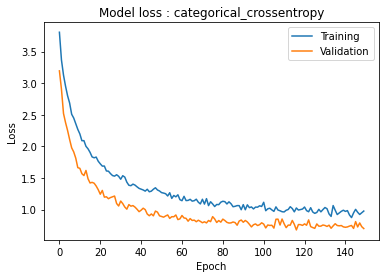

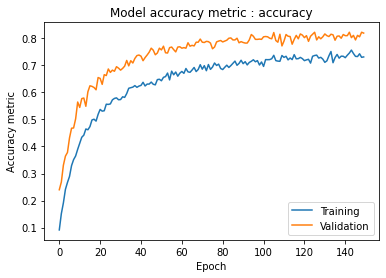

In [ ]:
plot_loss_and_accuracy(history_img)

In [ ]:
best_model_img.count_params()

2468246

**Evaluate final performance** 

In [ ]:
# Test accuracy 
_, accuracy, top_5_accuracy = best_model_img.evaluate(x_test_img, y_test_fuse, batch_size=BATCH_SIZE)

print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

60/60 [==============================] - 1s 23ms/step - loss: 0.6965 - accuracy: 0.8147 - top-5-accuracy: 0.9442
Test accuracy: 81.47%
Test top 5 accuracy: 94.42%


Load model

In [ ]:
best_model_img.save('model_save_img_further_trained')

INFO:tensorflow:Assets written to: model_save_img_further_trained/assets


INFO:tensorflow:Assets written to: model_save_img_further_trained/assets


In [17]:
# Load model and test accuracy to check if it matches
model_img_load = keras.models.load_model('model_save_img_further_trained')

_, accuracy, top_5_accuracy = model_img_load.evaluate(x_test_img, y_test_fuse, batch_size=BATCH_SIZE)

print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

60/60 [==============================] - 4s 13ms/step - loss: 0.6965 - accuracy: 0.8147 - top-5-accuracy: 0.9442
Test accuracy: 81.47%
Test top 5 accuracy: 94.42%


## Audio Images ViT tuning

### 1. Random tuner: objective = validation accuracy

In [ ]:
tuner_random_audio = RandomSearch(Single_ViT_HyperModel(input_shape = INPUT_SHAPE_AUDIO), objective='val_accuracy',executions_per_trial=1,project_name='Hyperparameters_rdm_audio',overwrite=True)

In [ ]:
tuner_random_audio.search_space_summary()

Search space summary
Default search space size: 5
patch_size (Choice)
{'default': 4, 'conditions': [], 'values': [4, 6, 12, 18, 24], 'ordered': True}
projection_dim (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
transformer_layers (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4, 6, 8], 'ordered': True}
num_heads (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5, 6, 7, 8], 'ordered': True}
mlp_head_units (Choice)
{'default': 512, 'conditions': [], 'values': [512, 256, 128], 'ordered': True}


In [ ]:
tuner_random_audio.search(x_train_audio, y_train_fuse, epochs=30, validation_data=(x_val_audio, y_val_fuse))

Trial 10 Complete [00h 01m 31s]
val_accuracy: 0.04736842215061188

Best val_accuracy So Far: 0.4231579005718231
Total elapsed time: 00h 26m 14s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_hyper_audio = tuner_random_audio.get_best_hyperparameters()[0]
print('For the Face images ViT, the best parameters are: ')
print(' - Patch size:            {}'.format(best_hps_hyper_audio.get('patch_size')))
print(' - Projection dimension:  {}'.format(best_hps_hyper_audio.get('projection_dim')))
print(' - Transformer layers:    {}'.format(best_hps_hyper_audio.get('transformer_layers')))
print(' - Number of heads:       {}'.format(best_hps_hyper_audio.get('num_heads')))
print(' - MLP head units:        [{}, {}]'.format(2*best_hps_hyper_audio.get('mlp_head_units'), best_hps_hyper_img.get('mlp_head_units')))

For the Face images ViT, the best parameters are: 
 - Patch size:            12
 - Projection dimension:  32
 - Transformer layers:    6
 - Number of heads:       2
 - MLP head units:        [1024, 512]


In [ ]:
model_audio = tuner_random_audio.hypermodel.build(best_hps_hyper_audio)
model_audio.save('model_save_audio')

INFO:tensorflow:Assets written to: model_save_audio/assets


INFO:tensorflow:Assets written to: model_save_audio/assets


In [ ]:
best_model_audio = keras.models.load_model('model_save_audio')

In [ ]:
max_epochs = 150
history_audio = best_model_audio.fit(x_train_audio, y_train_fuse, batch_size = BATCH_SIZE,
                    epochs = max_epochs,
                    validation_data=(x_val_audio, y_val_fuse),
                    shuffle = True)

Epoch 1/150
179/179 [==============================] - 17s 45ms/step - loss: 4.0166 - accuracy: 0.0305 - top-5-accuracy: 0.1544 - val_loss: 3.8451 - val_accuracy: 0.0432 - val_top-5-accuracy: 0.2158
Epoch 2/150
179/179 [==============================] - 7s 39ms/step - loss: 3.8791 - accuracy: 0.0379 - top-5-accuracy: 0.1747 - val_loss: 3.8533 - val_accuracy: 0.0368 - val_top-5-accuracy: 0.1800
Epoch 3/150
179/179 [==============================] - 7s 39ms/step - loss: 3.8577 - accuracy: 0.0435 - top-5-accuracy: 0.1768 - val_loss: 3.8088 - val_accuracy: 0.0463 - val_top-5-accuracy: 0.1789
Epoch 4/150
179/179 [==============================] - 7s 39ms/step - loss: 3.8288 - accuracy: 0.0414 - top-5-accuracy: 0.2004 - val_loss: 3.7981 - val_accuracy: 0.0484 - val_top-5-accuracy: 0.2137
Epoch 5/150
179/179 [==============================] - 8s 43ms/step - loss: 3.7974 - accuracy: 0.0554 - top-5-accuracy: 0.2081 - val_loss: 3.6809 - val_accuracy: 0.0705 - val_top-5-accuracy: 0.2884
Epoch 6/1

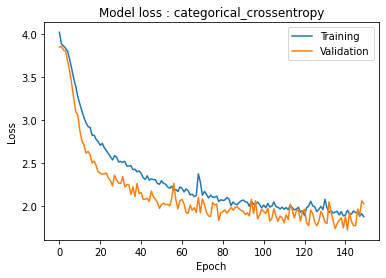

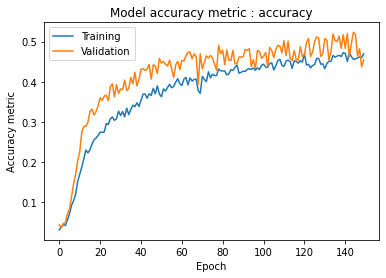

In [ ]:
plot_loss_and_accuracy(history_audio)

**Evaluate final performance** 

In [ ]:
# Test accuracy 
_, accuracy, top_5_accuracy = best_model_audio.evaluate(x_test_audio, y_test_fuse, batch_size=BATCH_SIZE)

print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

60/60 [==============================] - 1s 15ms/step - loss: 1.9047 - accuracy: 0.4789 - top-5-accuracy: 0.7947
Test accuracy: 47.89%
Test top 5 accuracy: 79.47%


In [ ]:
best_model_audio.count_params()

2931838

In [ ]:
best_model_audio.save('model_save_audio_further_trained')

INFO:tensorflow:Assets written to: model_save_audio_further_trained/assets


INFO:tensorflow:Assets written to: model_save_audio_further_trained/assets


In [18]:
# Load model and test accuracy to check if it matches
model_audio_load = keras.models.load_model('model_save_audio_further_trained')

_, accuracy, top_5_accuracy = model_audio_load.evaluate(x_test_audio, y_test_fuse, batch_size=BATCH_SIZE)

print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

60/60 [==============================] - 2s 14ms/step - loss: 1.9047 - accuracy: 0.4789 - top-5-accuracy: 0.7947
Test accuracy: 47.89%
Test top 5 accuracy: 79.47%


# Ensemble model

- Machine learning approach to combine multiple other models in the prediction process.
- The outputs of the image and audio models are combined using an aggregating method: the probability predictions for each label are summed and the label with the majority vote is predicted.

In [19]:
model_img = model_img_load
model_audio = model_audio_load

# Training 
proba_pred_train_img = tf.nn.softmax(model_img.predict(x_train_img))
proba_pred_train_audio = tf.nn.softmax(model_audio.predict(x_train_audio))
pred_train_img = np.argmax(proba_pred_train_img, axis=1) # (2850,)
pred_train_audio = np.argmax(proba_pred_train_audio, axis=1) # (2850,)

# Validation
proba_pred_val_img = model_img.predict(x_val_img)
proba_pred_val_audio = model_audio.predict(x_val_audio)
pred_val_img = np.argmax(proba_pred_val_img , axis=1) 
pred_val_audio = np.argmax(proba_pred_val_audio, axis=1) 

# Testing
proba_pred_test_img = model_img.predict(x_test_img)
proba_pred_test_audio = model_audio.predict(x_test_audio)
pred_test_img = np.argmax(proba_pred_test_img, axis=1) 
pred_test_audio = np.argmax(proba_pred_test_audio, axis=1) 

In [20]:
# Training accuracy 
train_acc_img = np.sum(pred_train_img==y_train_fuse)/len(pred_train_img)*100
train_acc_audio = np.sum(pred_train_audio==y_train_fuse)/len(pred_train_audio)*100
print('Train: audio accuracy {} and image accuracy {}'.format(train_acc_audio, train_acc_img))

# Validation accuracy 
val_acc_img = np.sum(pred_val_img==y_val_fuse)/len(pred_val_img)*100
val_acc_audio = np.sum(pred_val_audio==y_val_fuse)/len(pred_val_audio)*100
print('Valid: audio accuracy {} and image accuracy {}'.format(val_acc_audio, val_acc_img))

# Testing accuracy 
test_acc_img = np.sum(pred_test_img==y_test_fuse)/len(pred_test_img)*100
test_acc_audio = np.sum(pred_test_audio==y_test_fuse)/len(pred_test_audio)*100
print('Test : audio accuracy {} and image accuracy {}'.format(test_acc_audio, test_acc_img))

Train: audio accuracy 60.70175438596491 and image accuracy 94.56140350877193
Valid: audio accuracy 45.473684210526315 and image accuracy 81.89473684210526
Test : audio accuracy 47.89473684210526 and image accuracy 81.47368421052632


In [21]:
print('The audio and image predictors agree to {} on the training set'.format(np.sum(pred_train_img==pred_train_audio)/len(pred_train_audio)*100))
print('The audio and image predictors agree to {} on the validation set'.format(np.sum(pred_val_img==pred_val_audio)/len(pred_val_audio)*100))
print('The audio and image predictors agree to {} on the test set'.format(np.sum(pred_test_img==pred_test_audio)/len(pred_test_audio)*100))

The audio and image predictors agree to 58.73684210526315 on the training set
The audio and image predictors agree to 41.473684210526315 on the validation set
The audio and image predictors agree to 44.73684210526316 on the test set


The probability predictions for each label are summed and the label with the majority vote is predicted

In [22]:
# Training 
ensemble_pred_train = np.argmax(proba_pred_train_img + proba_pred_train_audio, axis = 1)
print('Train: ensemble model accuracy {}'.format(np.sum(ensemble_pred_train==y_train_fuse)/len(ensemble_pred_train)*100))

# Validation
ensemble_pred_val = np.argmax(proba_pred_val_img + proba_pred_val_audio, axis = 1)
print('Valid: ensemble model accuracy {}'.format(np.sum(ensemble_pred_val==y_val_fuse)/len(ensemble_pred_val)*100))

# Testing
ensemble_pred_test = np.argmax(proba_pred_test_img + proba_pred_test_audio, axis = 1)
print('Test : ensemble model accuracy {}'.format(np.sum(ensemble_pred_test==y_test_fuse)/len(ensemble_pred_test)*100))

Train: ensemble model accuracy 95.75438596491227
Valid: ensemble model accuracy 86.8421052631579
Test : ensemble model accuracy 88.21052631578948
